딥러닝파이토치 교과서 ch5. 2
 p.179~200

# CH5. 합성곱 신경망 1

## 5.2 합성곱 신경망 맛보기

fashion_mnist 데이터셋을 사용하여 합성곱 신경망 구현하기

-------
[fastion_mnist 데이터셋]
- 작은 이미지의 모음
- 28 x 28 픽셀의 이미지 7만 개로 구성됨

-------

라이브러리 호출

In [36]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms # 데이터 전처리를 위해 사용하는 라이브러리
from torch.utils.data import Dataset, DataLoader

CPU 혹은 GPU 장치 확인

In [37]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

fasion_mnist 데이터셋 내려받기

In [39]:
train_dataset = torchvision.datasets.FashionMNIST("FashionMNIST/", download=True, transform=transforms.Compose([transforms.ToTensor()]))
test_dataset = torchvision.datasets.FashionMNIST("FashionMNIST/", download=True, train=False, transform=transforms.Compose([transforms.ToTensor()]))

fation_mnist 데이터를 데이터로더에 전달

In [40]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=100)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=100)

분류에 사용될 클래스 정의

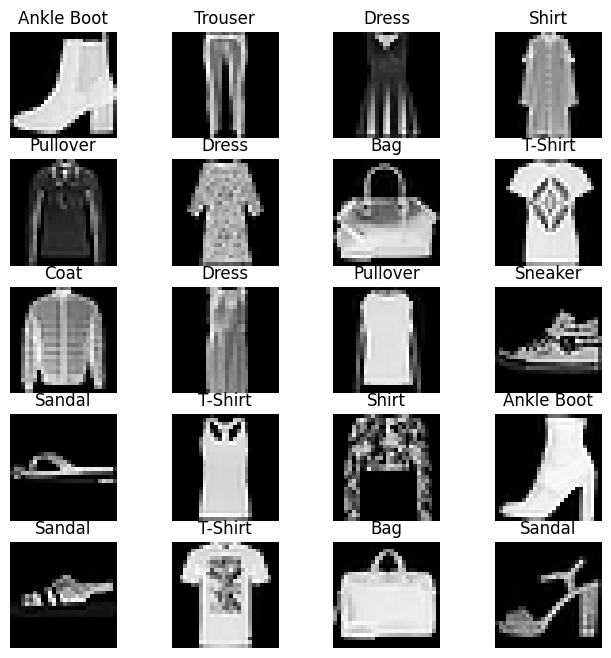

In [41]:
labels_map = {0: 'T-Shirt', 1: 'Trouser', 2: 'Pullover', 3: 'Dress', 4:'Coat',
              5: 'Sandal', 6:'Shirt', 7:'Sneaker', 8:'Bag', 9:'Ankle Boot'} # 10개의 클래스

fig = plt.figure(figsize=(8,8)) ; # 출력할 이미지의 가로세로 길이로 단위는 inch
columns = 4;
rows = 5;
for i in range(1, columns*rows +1):
    img_xy = np.random.randint(len(train_dataset)); # 1
    img = train_dataset[img_xy][0][0, : ,:] # 2
    fig.add_subplot(rows, columns, i)
    plt.title(labels_map[train_dataset[img_xy][1]])
    plt.axis('off')
    plt.imshow(img, cmap='gray')
plt.show() # 20개의 이미지 데이터를 시각적으로 표현

----
1.
- np.random : 무작위로 데이터를 생성할 때 사용
- np.random.randint() : 이산형 분포를 갖는 데이터에서 무작위 표본을 추출할 때 사용
- random.randint(len(train_dataset)) : 0~(train_dataset의 길이) 값을 갖는 분포에서 랜덤한 숫자 한 개를 생성하라는 의미




In [42]:
import numpy as np

np.random.randint(10) # 0~10의 임의의 숫자를 출력

7

In [43]:
np.random.randint(1, 10) # 1~9의 임의의 숫자를 출력

6

In [44]:
np.random.rand(8) # 0~1 사이의 정규표준분포 난수를 행렬로 (1x8) 출력

array([0.7696191 , 0.18190016, 0.00816886, 0.81745231, 0.03986301,
       0.19425749, 0.98976593, 0.36282725])

In [45]:
np.random.rand(4,2) # 0~1 사이의 정규표준분포 난수를 행렬로 (4x2) 출력

array([[0.1393559 , 0.22849472],
       [0.33208432, 0.88786821],
       [0.69115773, 0.81875156],
       [0.09118185, 0.32957186]])

In [46]:
np.random.randn(8) # 평균이 0이고 표준편차가 1인 가우시안 정규분포 난수를 행렬로 (1x8) 출력

array([-0.28629567, -1.28778331, -0.72180797,  0.44328414,  0.85478957,
       -0.13368341, -0.98325419, -0.27095068])

In [47]:
np.random.randn(4,2) # 평균이 0이고 표준편차가 1인 가우시안 정규분포 난수를 행렬로 (4x2) 출력

array([[ 0.61654143, -0.34170979],
       [-0.16556989, -0.51556473],
       [-0.04980947,  0.47239272],
       [ 1.82755135, -0.52763207]])

2. train_dataset을 이용한 3차원 배열을 생성

In [48]:
import numpy as np
examp = np.arange(0,100,3) # 1~99 의 숫자에서 3씩 건너뛴 행렬을 생성
examp.resize(6,4) # 행렬의 크기를 6x4로 조정
examp

array([[ 0,  3,  6,  9],
       [12, 15, 18, 21],
       [24, 27, 30, 33],
       [36, 39, 42, 45],
       [48, 51, 54, 57],
       [60, 63, 66, 69]])

In [49]:
examp[3] # 3행에 해당하는 모든 요소들을 출력

array([36, 39, 42, 45])

In [50]:
examp[3,3] # 3행의 3번째 열에 대한 값을 출력

np.int64(45)

In [51]:
examp[3][3] # 3행의 3번째 열에 대한 값을 출력하기 때문에 바로 앞의 결과와 동일

np.int64(45)

In [52]:
examp = np.arange(0,500,3)
examp.resize(3,5,5)
examp

array([[[  0,   3,   6,   9,  12],
        [ 15,  18,  21,  24,  27],
        [ 30,  33,  36,  39,  42],
        [ 45,  48,  51,  54,  57],
        [ 60,  63,  66,  69,  72]],

       [[ 75,  78,  81,  84,  87],
        [ 90,  93,  96,  99, 102],
        [105, 108, 111, 114, 117],
        [120, 123, 126, 129, 132],
        [135, 138, 141, 144, 147]],

       [[150, 153, 156, 159, 162],
        [165, 168, 171, 174, 177],
        [180, 183, 186, 189, 192],
        [195, 198, 201, 204, 207],
        [210, 213, 216, 219, 222]]])

In [53]:
examp[2][0][3]

np.int64(159)

----
합성곱 신경망 vs 합성곱 신경망이 아닌 심층 신경망

심층 신경망 생성 후 학습시키기

In [54]:
# 심층 신경망 모델 생성

class FashionDNN(nn.Module) :
    def __init__(self) : # 1
        super(FashionDNN, self).__init__()
        self.fc1 = nn.Linear(in_features=784, out_features=256) # 2
        self.drop = nn.Dropout(0.25) # 3
        self.fc2 = nn.Linear(in_features=256, out_features=128)
        self.fc3 = nn.Linear(in_features=128, out_features=10)

    def forward(self, input_data) : # 4
        out = input_data.view(-1, 784) # 5
        out = F.relu(self.fc1(out)) # 6
        out = self.drop(out)
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out

---
1. class 형태의 모델
- 항상 torch.nn.Moudule을 상속 받음
- __init__() : 객체가 갖는 속성 값을 초기화하는 역할, 객체가 생성될 때 자동으로 호출됨
- super(FasionDNN, self).__init__() : nn.Module 클래스를 상속받는다는 의미

2. nn.Linear
- nn : 딥러닝 모델 구성에 필요한 모듈이 모여 있는 패키지
- LInear : 단순 선형 회귀 모델을 만들 때 사용

3. torch.nn.Dropout(p) : p만큼의 비율로 텐서의 값이 0이 되고, 0이 되지 않은 값들은 기존 값에 (1/(1-p))만큼 곱해져 커짐

4. forward() 함수 : gkrtmq epdlxjfmf dlqfur qkedktj tnswjsvk gkrtmqdmf wlsgod

5. view() : 넘파이의 reshape과 같은 역할

6. 활성화 함수 지정 방법
- F.relu() : forward() 함수에서 정의
- nn.ReLU() : __init__() 함수에서 정의

In [55]:
## nn 사용 예시 코드
import torch
import torch.nn as nn

inputs = torch.randn(64, 3, 244, 244)
conv = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1)
# 세 개의 채널이 입력되어 64개의 채널이 출력되기 위한 연산 -> 3x3 크기의 커널 사용
outputs = conv(inputs)
layer = nn.Conv2d(1,1,3)

In [56]:
## nn.functional 사용 예시 코드
import torch.nn.functional as F

inputs = torch.randn(64, 3, 244, 244)
weight = torch.randn(64, 3, 3, 3)
bias = torch.randn(64)
outputs = F.conv2d(inputs, weight, bias, padding=1)

- 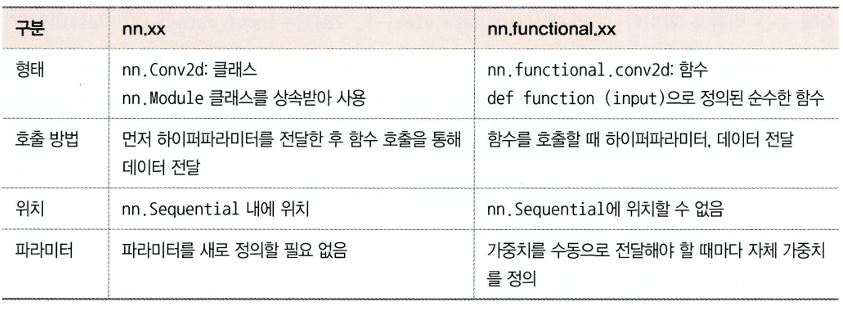

---------

심층 신경망에서 필요한 파라미터 정의
- 손실함수, 학습률, 옵티마이저

In [57]:
learning_rate = 0.001;
model = FashionDNN();
model.to(device)

criterion = nn.CrossEntropyLoss(); # 분류 문제에서 사용하는 손실 함수
optimizer = torch.optim.Adam(model.parameters(), lr =learning_rate); #1
print(model)

FashionDNN(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (drop): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)


1. 옵티마이저를 위한 경사 하강법 : Adam 사용
--------

심층 신경망을 이용한 모델 학습

In [58]:
import torch
from torch.autograd import Variable

num_epochs = 5
count = 0

loss_list = [] # 1
iteration_list = []
accuracy_list= []

predictions_list = []
labels_list = []

for epoch in range(num_epochs):
    for images, labels in train_loader: # 2
        images, labels = images.to(device), labels.to(device) # 3

        train = Variable(images.view(100,1,28,28)) # 4
        labels = Variable(labels)

        outputs = model(train) # 학습 데이터를 모델에 적용
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        count += 1

        if not (count % 50): # count를 50으로 나누었을 때 나머지가 0이 아니라면 실행
            total = 0
            correct = 0
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                labels_list.append(labels)
                test = Variable(images.view(100,1,28,28))
                outputs = model(test)
                predictions = torch.max(outputs, 1)[1].to(device)
                predictions_list.append(predictions)
                correct += (predictions == labels).sum().item()
                total += len(labels)

            accuracy = correct * 100 / total # 5
            loss_list.append(loss.item()) # 1
            iteration_list.append(count)
            accuracy_list.append(accuracy)

        if not (count % 500):
            print('Iteration: {}, Loss: {:.4f}, Accuracy: {:.2f} %'.format(count, loss.item(), accuracy))


Iteration: 500, Loss: 0.5661, Accuracy: 83.60 %
Iteration: 1000, Loss: 0.4580, Accuracy: 84.57 %
Iteration: 1500, Loss: 0.3738, Accuracy: 84.53 %
Iteration: 2000, Loss: 0.4307, Accuracy: 85.51 %
Iteration: 2500, Loss: 0.2630, Accuracy: 85.97 %
Iteration: 3000, Loss: 0.2983, Accuracy: 86.36 %


1. 리스트

2. for 구문 사용해 레코드를 하나씩 가져오기
- 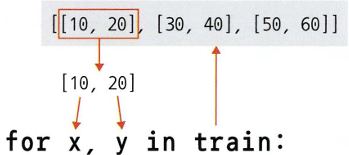

3. 모델이 데이터를 처리하기 위해 모델과 데이터가 동일한 장치에 있어야 함

4. Autograd : 자동 미분을 수행하는 파이토치의 패키지

5. 분류 문제의 정확도 = correct predictions / total predictions

--------
합성곱 네트워크 생성

In [59]:
class FashionCNN(nn.Module) :
    def __init__(self) :
        super(FashionCNN, self).__init__()
        self.layer1 = nn.Sequential(  # 1
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1), # 2
            nn.BatchNorm2d(32), # 3
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2) # 4
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.fc1 = nn.Linear(in_features=64*6*6, out_features=600) # 5
        self.drop = nn.Dropout2d(0.25)
        self.fc2 = nn.Linear(in_features=600, out_features=120)
        self.fc3 = nn.Linear(in_features=120, out_features=10) # 마지막 계층의 out_features는 클래스 개수를 의미

    def forward(self, x) :
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1) # 6
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)
        return out


1. nn.Sequential
- __init__() 에서 사용할 네트워크 모델들을 정의
- forward() 함수에서 구현될 순전파를 계층 형태로 가독성이 뛰어난 코드로 작성 가능
- 계층을 차례로 쌓을 수 있도록 Wx+b 와 같은 수식과 활성화 함수를 연결하는 역할

2. 합성곱 층 : 합성곱 연산을 통해서 이미지의 특징을 추출


```
nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
```
- in_channels :  입력 채널 수
- out_channels : 출력 채널 수
- kernel_size : 커널 크기, 필터
- padding : 패딩 크기, 입력 데이터 주위에 0 채우기

3. BatchNorm2d : 학습 과정에서 각 배치 단위별로 데이터가 다양한 분포를 가지더라도 평균과 분산을 이용하여 정규화하는 것을 의미함
- 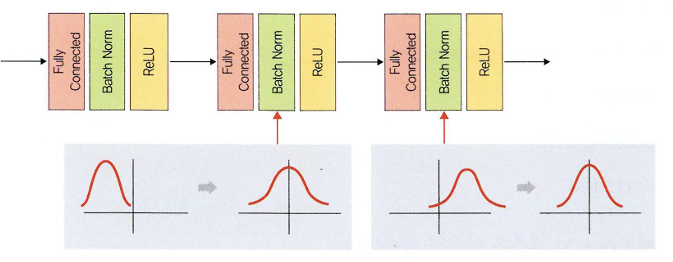


4. MaxPool2d : 이미지 크기를 축소시키는 용도로 사용
- 풀링 계층 : 합성곱층의 출력 데이터를 입력으로 받아서 출력 데이터의 크기를 줄이거나 특정 데이터를 강조하는 용도로 사용
 - 최대 풀링, 평균 풀링, 최소 풀링

5. 클래스 분류를 위해 이미지 형태의 데이터를 배열 형태로 변환하여 작업
- in_features : 입력 데이터의 크기
- out_features : Conv2d에서 사용하는 하이퍼파라미터 값들에 따라 출력 크기가 달라짐
 - Conv2d 계층에서의 출력 크기 구하는 공식
 - 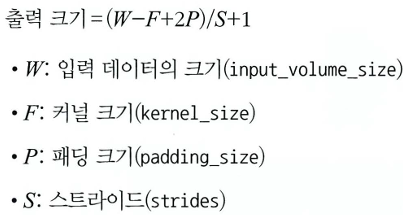
 - MaxPool2d 계층에서의 출력 크기 구하는 공식
 - 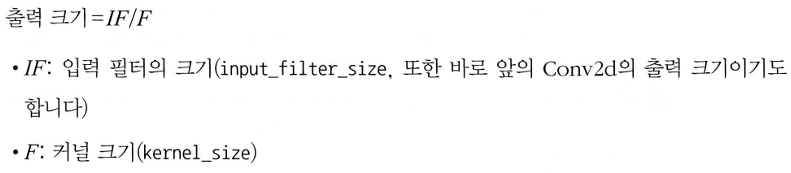

-------------
합성곱 네트워크를 사용하기 위한 파라미터를 정의

In [60]:
learning_rate = 0.001;
model = FashionCNN();
model.to(device)

criterion = nn.CrossEntropyLoss();
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate);
print(model)

FashionCNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=2304, out_features=600, bias=True)
  (drop): Dropout2d(p=0.25, inplace=False)
  (fc2): Linear(in_features=600, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=10, bias=True)
)


학습 데이터 이용하여 모델 학습 및 성능 평가

In [62]:
import torch
from torch.autograd import Variable

num_epochs = 5
count = 0

loss_list = []
iteration_list = []
accuracy_list= []

predictions_list = []
labels_list = []

for epoch in range(num_epochs):
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        train = Variable(images.view(100,1,28,28))
        labels = Variable(labels)

        outputs = model(train) # 학습 데이터를 모델에 적용
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        count += 1

        if not (count % 50): # count를 50으로 나누었을 때 나머지가 0이 아니라면 실행
            total = 0
            correct = 0
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                labels_list.append(labels)
                test = Variable(images.view(100,1,28,28))
                outputs = model(test)
                predictions = torch.max(outputs, 1)[1].to(device)
                predictions_list.append(predictions)
                correct += (predictions == labels).sum().item()
                total += len(labels)

            accuracy = correct * 100 / total
            loss_list.append(loss.item())
            iteration_list.append(count)
            accuracy_list.append(accuracy)

        if not (count % 500):
            print('Iteration: {}, Loss: {:.4f}, Accuracy: {:.2f} %'.format(count, loss.item(), accuracy))


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Iteration: 500, Loss: 0.4885, Accuracy: 87.60 %
Iteration: 1000, Loss: 0.3608, Accuracy: 87.38 %
Iteration: 1500, Loss: 0.3030, Accuracy: 88.40 %
Iteration: 2000, Loss: 0.2017, Accuracy: 89.38 %
Iteration: 2500, Loss: 0.1612, Accuracy: 89.46 %
Iteration: 3000, Loss: 0.1653, Accuracy: 89.19 %
